# Handwritten Digit Recognition with Convolutional Neural Nets


## Setup

In [1]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
# utility functions
def show_images(images, min_width = 0):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))
    
    sqrtn = max(min_width, sqrtn)
        
    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def visualise_errors(incorrect_classifications):
    for digit_class in range(10):        
        sample = [class_prototype[digit_class]] + incorrect_classifications[digit_class][:15]            
        show_images(X_test[sample,:], 16)        

## Dataset

We will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 

To simplify our code here, we will use the TensorFlow MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 


Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


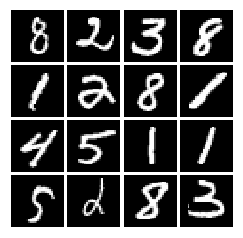

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./MNIST_data', one_hot=True)

# show a batch
show_images(mnist.train.next_batch(16)[0])

# k-Nearest Neigbours (kNN)

The idea behind kNN is to classify a digit by looking at its 'closest' analogy.  That is, to compare an unknown digit to a set of known digits.  

Some problems can be solved quite well by this deceptively simple algorithm, especially if a good distance metric is used.  

The 'k' in kNN refers the number of closest examples to consider.  For example, k=5 would mean to take the 5 most similar digits and pick the most common one.

Each problem will have a different best k value.  But 3 or 5 usually works quite well.

kNN is also great at providing a **baseline**.  A more advanced model performing worse than kNN is a strong indicator of a bug in your algorithm.


### Split the test and training data

The goal is to learn how to predict **y** from **X**.  Where **X** is is the image, and **y** is the label (i.e. 0,1,2...)

We will use the training data to learn how to predict digits, and the test data to check how well the model is working.  It is important that the model never sees the test data.

In [5]:
# we sample down to 5000 training examples, and 500 test examples.
X_train, y_train = mnist.train.next_batch(5000) 
X_test, y_test = mnist.test.next_batch(500)
class_prototype = [np.argmax(y_test, axis = 1).tolist().index(digit_class) for digit_class in range(10)]

### Setup the Model

Now we setup our model in TensorFlow.  At this point, *we are not doing any of the calculations*.  We are simply creating a graph that will be used during training.  You can think of this as creating a 'blueprint' describing what calculations to perform during training.

TensorFlow operations can be performed using method calls, e.g. c = tf.add(a,b), or by using operators, e.g. c = a + b

We will also make use of the tf.nn module which contains some very useful support functions for neural nets.

The following code was modified from the [tensorflow examples](https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/2_BasicModels/nearest_neighbor.py)

In [6]:
# Placeholders allow use to 'plug' data into the graph during training.
X_train_placeholder = tf.placeholder(tf.float32, [None, 784])
X_test_placeholder = tf.placeholder(tf.float32, [784])

# Calculate the L1 distance
distance = tf.reduce_sum(tf.abs(X_train_placeholder - X_test_placeholder), axis=1)

# Prediction: Get min distance index (Nearest neighbor)
# This is equiv to k=1
pred = tf.arg_min(distance, 0)

### Train

The kNN algorithm doesn't really need to train, as it simply memorises the training data.  So at this point we are simply going to evaluate the accuracy of the model.

In [7]:
print("Training...")

accuracy = 0.0
incorrect_classifications = [[] for _ in range(10)]

# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(tf.global_variables_initializer())
    
    # loop over  test data
    for i in range(len(X_test)):
        # Get nearest neighbor
        nn_index = sess.run(pred, feed_dict={X_train_placeholder: X_train, X_test_placeholder: X_test[i, :]})
        predicted_class = np.argmax(y_train[nn_index])
        true_class = np.argmax(y_test[i])        
        # Calculate accuracy
        if predicted_class == true_class:
            accuracy += 1.0/len(X_test)            
        else:
            # record the mistakes
            incorrect_classifications[predicted_class].append(i)
            
            
print("Done!")
print("Accuracy: {0:.2f}%".format(accuracy*100))

Training...
Done!
Accuracy: 91.80%


### Inspecting the misclassified examples

It's always a good idea to take a look at what kinds of errors the algorithm is making.

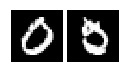

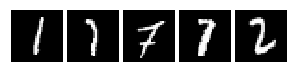

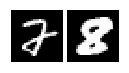

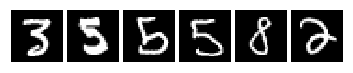

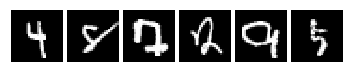

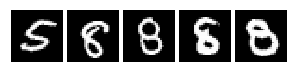

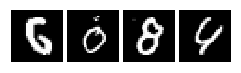

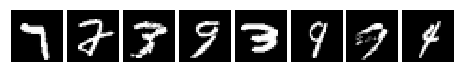

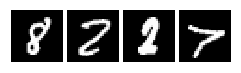

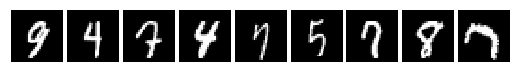

In [8]:
# Display some missclassifed examples
# The first digit is the correct classification.
visualise_errors(incorrect_classifications)

# 3. Convolutional Neural Net

### What is a Convolutional Neural Net?


In a standard neural net, each neuron responds based on a linear combination of inputs from the previous layer.

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" width = 40%>

In a convolutional neural net, each neuron is a 'filter' which responds to different kinds of 2d patterns.  At the base layers, these will simply be edge detectors, but higher layers neurons will trigger on more abstract concepts.  Each filter is run over the entire image and outputs a new image with the applied filter.  These filtered images are then 'stacked' on top of each other to create a 3D volume used as the input to the next layer.

<img src="http://cs231n.github.io/assets/cnn/cnn.jpeg", width = 40%>

We add pooling layers that reduce the size of the image.  The idea being that at deeper layers the exact details are not needed, just the general ideas.  Typically these pooling layers reduce the size of the image by 2 in each direction.

<img src="http://cs231n.github.io/assets/cnn/convnet.jpeg">


See the [CS231n](http://cs231n.github.io/convolutional-networks/) site for more information.

Note: The following code was modified from [this](https://www.tensorflow.org/tutorials/layers) TensorFlow example.

## Single layer CCN

In [9]:
# This time we will use the entire dataset.
X_train, y_train = mnist.train.images, mnist.train.labels
X_test, y_test = mnist.test.images, mnist.test.labels
class_prototype = [np.argmax(y_test, axis = 1).tolist().index(digit_class) for digit_class in range(10)]

In [10]:
# Helper functions for training / evaluation.

def eval_model():
    print("-"*60)
    test_accuracy = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0})
    print("Test Error Rate {0:.2f}%".format((1-test_accuracy)*100))
    
    predictions = pred.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0})
    pred_class = np.argmax(predictions, axis = 1)
    true_class = np.argmax(mnist.test.labels, axis = 1)
    
    incorrect_classifications = [[] for _ in range(10)]
        
    for i in range(true_class.shape[0]):
        if pred_class[i] != true_class[i]:
            incorrect_classifications[pred_class[i]].append(i)
            
    visualise_errors(incorrect_classifications)    
    

# train the model...
def train_model(epochs = 10, batch_size = 64):

    print("Training...")

    init = tf.global_variables_initializer()
    
    iterations = int(epochs * len(mnist.train.labels) / batch_size)

    # Start training
    with tf.Session() as sess:

        # Run the initializer
        sess.run(init)

        for i in range(iterations):

            # get a new batch
            batch = mnist.train.next_batch(batch_size)            

            # evaluate every 100 steps
            if i % 1000 == 0:
                val_batch = mnist.validation.next_batch(1000)
                train_batch = mnist.validation.next_batch(1000)

                train_accuracy = accuracy.eval(feed_dict={X: train_batch[0], y: train_batch[1], keep_prob: 1.0})
                val_accuracy = accuracy.eval(feed_dict={X: val_batch[0], y: val_batch[1], keep_prob: 1.0}) 

                loss_eval = loss.eval(feed_dict={X: batch[0], y: batch[1], keep_prob: 0.5})            
                
                epoch = (batch_size * i) / len(mnist.train.labels)

                print('[epoch=%g] step %d, training accuracy %g validation accuracy %g loss %g' % (epoch, i, train_accuracy, val_accuracy, loss_eval))        

            # train on this batch
            train_op.run(feed_dict={X: batch[0], y: batch[1], keep_prob: 0.5})

        eval_model()

### Setup the Model

In [11]:
# these are our placeholders
X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])
keep_prob = tf.placeholder(tf.float32)

# The MNIST dataset has stores images as long 1D vectors, but we want them in 2D.
reshaped_X = tf.reshape(X, [-1, 28, 28, 1])

# A Convolutional Layer
conv1 = tf.layers.conv2d(
    inputs = reshaped_X,
    filters = 32,
    kernel_size = [5, 5],
    padding = "same",
    activation = tf.nn.relu)

# Pool layer
pool1 = tf.layers.max_pooling2d(inputs = conv1, pool_size = [2, 2], strides = [2, 2])
pool1 = tf.reshape(pool1, [-1, 14 * 14 * 32])

# Dense layer
pred = tf.layers.dense(inputs = pool1, units = 10, activation = None)

# Prediction with softmax
correct_prediction = tf.equal(tf.argmax(pred, axis = 1), tf.argmax(y, axis = 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

loss = tf.losses.softmax_cross_entropy(onehot_labels = y, logits = pred)

# setup our training loss
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
train_op = optimizer.minimize(loss=loss)    

Training...
[epoch=0] step 0, training accuracy 0.055 validation accuracy 0.062 loss 2.34596
[epoch=1.16364] step 1000, training accuracy 0.976 validation accuracy 0.975 loss 0.0424402
[epoch=2.32727] step 2000, training accuracy 0.982 validation accuracy 0.985 loss 0.051388
[epoch=3.49091] step 3000, training accuracy 0.983 validation accuracy 0.982 loss 0.033959
[epoch=4.65455] step 4000, training accuracy 0.989 validation accuracy 0.989 loss 0.00305222
[epoch=5.81818] step 5000, training accuracy 0.986 validation accuracy 0.977 loss 0.011742
[epoch=6.98182] step 6000, training accuracy 0.992 validation accuracy 0.986 loss 0.0583118
[epoch=8.14545] step 7000, training accuracy 0.989 validation accuracy 0.986 loss 0.00730143
[epoch=9.30909] step 8000, training accuracy 0.98 validation accuracy 0.989 loss 0.0220421
------------------------------------------------------------
Test Error Rate 1.33%


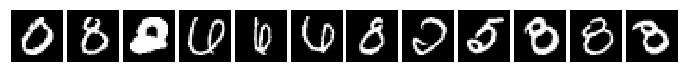

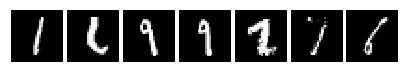

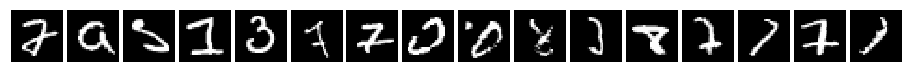

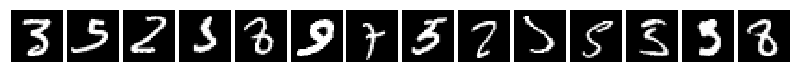

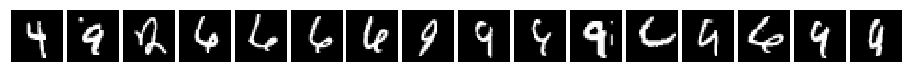

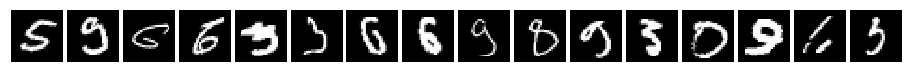

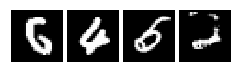

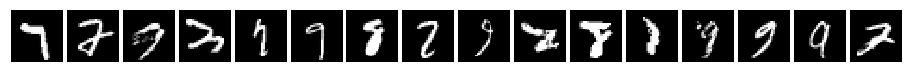

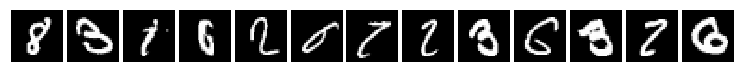

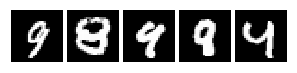

In [12]:
train_model()

## Two layer CCN

Two layer model based on [LeNet-5](http://yann.lecun.com/exdb/lenet/ )

See (http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)

In [13]:
# conv layer 1, 
c1 = tf.layers.conv2d(inputs = reshaped_X, filters = 20, kernel_size = [5,5], padding = "same", activation = tf.nn.relu)
c1 = tf.layers.max_pooling2d(inputs = c1, pool_size = [2,2], strides = 2)

# Conv layer 2, 
c2 = tf.layers.conv2d(inputs = c1, filters = 50, kernel_size = [5,5], padding = "same", activation = tf.nn.relu)
c2 = tf.layers.max_pooling2d(inputs = c2, pool_size = [2,2], strides = 2)

# dense layer1
flat = tf.reshape(c2, [-1, 7*7*50])
h1 = tf.layers.dense(inputs = flat, units = 500, activation = tf.nn.relu)
h1 = tf.nn.dropout(h1, keep_prob)

# dense layer2
pred = tf.layers.dense(inputs = h1, units = 10, activation = None)

# prediction with softmax
class_out = tf.argmax(pred, axis = 1)
pred_out = tf.nn.softmax(pred)

correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

loss = tf.losses.softmax_cross_entropy(onehot_labels = y, logits = pred)

# setup our training loss
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
train_op = optimizer.minimize(loss=loss)    

Training...
[epoch=0] step 0, training accuracy 0.048 validation accuracy 0.047 loss 2.29975
[epoch=1.16364] step 1000, training accuracy 0.984 validation accuracy 0.989 loss 0.069772
[epoch=2.32727] step 2000, training accuracy 0.99 validation accuracy 0.989 loss 0.0461266
[epoch=3.49091] step 3000, training accuracy 0.989 validation accuracy 0.99 loss 0.0128566
[epoch=4.65455] step 4000, training accuracy 0.993 validation accuracy 0.992 loss 0.0481639
[epoch=5.81818] step 5000, training accuracy 0.99 validation accuracy 0.995 loss 0.117133
[epoch=6.98182] step 6000, training accuracy 0.991 validation accuracy 0.996 loss 0.00545745
[epoch=8.14545] step 7000, training accuracy 0.993 validation accuracy 0.991 loss 0.00356731
[epoch=9.30909] step 8000, training accuracy 0.986 validation accuracy 0.991 loss 0.0029888
------------------------------------------------------------
Test Error Rate 0.73%


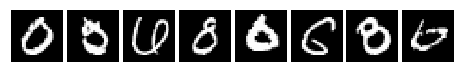

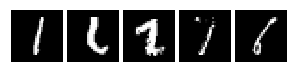

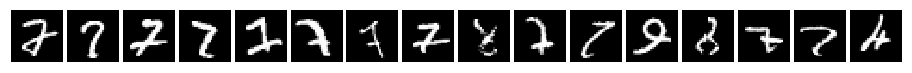

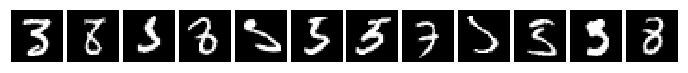

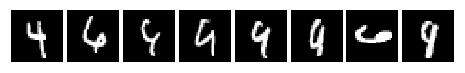

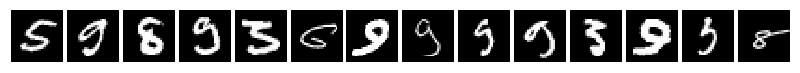

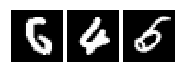

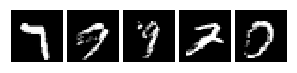

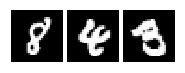

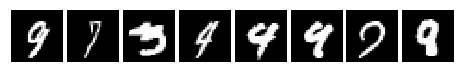

In [14]:
train_model() 